# Think Bayes solutions: Chapter 4

This notebook presents solutions to exercises in Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import numpy as np
import random
import os
import sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot

from Beta import Beta

% matplotlib inline

**Exercise:** One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want.  Then when you do an update, the data get added to the parameters of the prior.  Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points.  Construct a prior that captures this belief and update it with the Euro data.  How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters `(1, 1)` is uniform from 0 to 1.

**Solution**

The Beta distribution is roughly described by $\textrm{Beta}(x) = x^{\alpha -1}(1-x)^{\beta -1}$. What I want is a distribution which is peaked around the center, and with symmetrical, slim tails (like a narrow Gaussian distribution).

The mean of a Beta distribution is $\textrm{Mean} = \frac{\alpha}{\alpha + \beta}$, and the mode is $\textrm{Mode} = \frac{\alpha -1}{\alpha + \beta -2}$. I want both of these to be equal to 0.5.

In addition, the variance of the Beta distribution is $\textrm{Variance} = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$. Since I don't believe this will deviate from 0.5 by much, I want this to be small, say 0.01.

Now, I have a set of equations with which I can solve for $\alpha$ and $\beta$.

From my mean, since $\frac{\alpha}{\alpha + \beta} = 0.5$, its clear that $\alpha = \beta$. Substituting this into my equation for the variance,

$0.01 = \frac{\alpha^2}{2\alpha^2(2\alpha + 1)}$

Solving for $\alpha$ yields $\alpha = \frac{0.98}{0.04} = 24.5$. This is the value of my $\alpha$ and $\beta$ parameters!

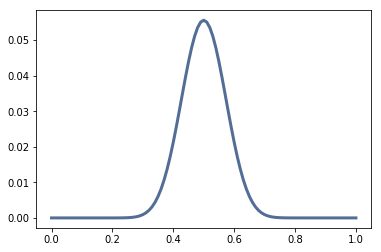

In [2]:
centered_beta = Beta(alpha=24.5, beta=24.5, label='centered prior')
thinkplot.Pdf(centered_beta.MakePmf())

I can use this with the coin experiment:

In [3]:
centered_beta.Update((140, 110))
centered_beta.Mean()

0.5501672240802675

Comparing this with a uniform prior,

In [4]:
uniform_beta = Beta(alpha=1, beta=1, label='centered_prior')
uniform_beta.Update((140, 110))

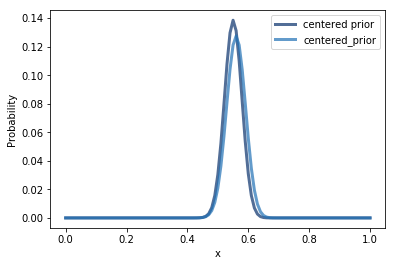

In [5]:
thinkplot.Pdfs([centered_beta.MakePmf(), uniform_beta.MakePmf()]) 
thinkplot.Config(xlabel='x', ylabel='Probability')

So the centered prior yields a very similar distribution to the uniform prior. We can better quantify the differences in these distributions by comparing their means, and credible intervals.

In [6]:
print ('Means \nUniform prior: {} \nCentered prior: {}'.format(uniform_beta.Mean(), centered_beta.Mean()))

Means 
Uniform prior: 0.559523809524 
Centered prior: 0.55016722408


The peaks are not identical, but there is a less than 2% difference between the means.

In [7]:
print ('Credible Interavals \nUniform prior: {}\nCentered prior: {}'.format(uniform_beta.Percentile([5, 95]),
                                                                             centered_beta.Percentile([5, 95])))

Credible Interavals 
Uniform prior: [ 0.50790363  0.6106057 ]
Centered prior: [ 0.50272228  0.59722994]


**Exercise:**  At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match.  They each hit 15 of 25 skeets, sending the match into sudden death.  In the first round, both hit 1 of 2 skeets.  In the next two rounds, they each hit 2 skeets.  Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei?  If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet.  Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them.  To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

**Solution**
I can model my hypotheses as some percentage chance, $x$, that Rhode and Meng would hit the skeets. In the language of the coin flip, hitting a skeet would be 'heads', and missing it would be 'tails'.

In this simulation, Rhode would have $(15 + 1 + 2 + 2) = 20$ heads and $(10 + 1 + 1) = 12$ tails.
Meng would have $19$ heads and $13$ tails.

In terms of the prior, I don't think a uniform prior is entirely appropriate here, since it's silly that professional athletes will have the same likelihood of getting 0 shots as getting all of them.

A little bit of searching yielded these [two](https://www.thehighroad.org/index.php?threads/skeet-score-good-bad-average.595866/) [forums](https://www.thehighroad.org/index.php?threads/skeet-score-good-bad-average.595866/), which seem to suggest that

1. scores have a very high variance (*"I won a tournament w/ a 79 once and came in 6th w/ a 92....it all depends on the difficulty of the targets. Period."*)
2. scores ranging from 60% - 80% seem to be normal (for the hobbyists who frequent online skeet shooting forums).

Its not much, but its a start. Let's shoot for a mode of 75, and a variance of 0.05. Solving for the mode,

$\frac{\alpha -1}{\alpha + \beta -2} = 0.75$, so that $\alpha = 3\beta -2$.

Plugging this into the variance, $\frac{(3\beta -2)\beta}{(4\beta -2)^2(4\beta -1)} = 0.2$, which yields $\beta = 1.43$. This gives me $\alpha = 2.29$.

(To test swamping, and to see if we have enough data for the prior to not be that important, I am also going to do this with uniform priors and compare the results).

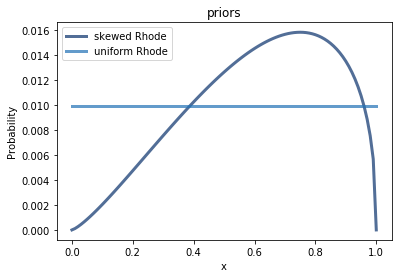

In [8]:
skewed_Rhode = Beta(alpha=2.29, beta=1.43, label='skewed Rhode')
skewed_Meng = Beta(alpha=2.29, beta=1.43, label='skewed Meng')
uniform_Rhode = Beta(label='uniform Rhode')
uniform_Meng = Beta(label='uniform Meng')

# let's see what this prior looks like
thinkplot.Pdfs([skewed_Rhode.MakePmf(), uniform_Rhode.MakePmf()]) 
thinkplot.Config(title='priors', xlabel='x', ylabel='Probability')

In [9]:
skewed_Rhode.Update((20, 12))
skewed_Meng.Update((19, 13))

uniform_Rhode.Update((20, 12))
uniform_Meng.Update((19, 13))

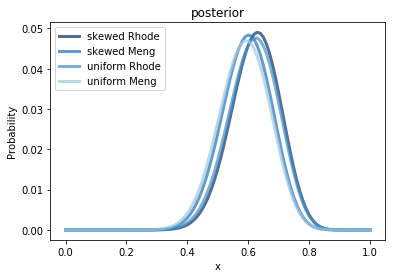

In [10]:
thinkplot.Pdfs([skewed_Rhode.MakePmf(), skewed_Meng.MakePmf(),
                uniform_Rhode.MakePmf(), uniform_Meng.MakePmf()]) 
thinkplot.Config(title='posterior', xlabel='x', ylabel='Probability')

In [11]:
skewed_Rhode.Mean(), skewed_Meng.Mean(), uniform_Rhode.Mean(), uniform_Meng.Mean()

(0.624020156774916, 0.5960246360582306, 0.6176470588235294, 0.5882352941176471)

Considering that there is relatively little data to work with here - 32 datapoints - it's interesting that such different priors yield such similar posteriors. Both have a similar conclusion; that Rhode is a slightly better shooter than Meng. Who would win in a rematch?

In [12]:
skewed_rhodes = skewed_Rhode.Sample(25)
skewed_meng = skewed_Meng.Sample(25)

num_rhodes_skewed = len(skewed_rhodes[skewed_rhodes > 0.5])
num_meng_skewed = len(skewed_meng[skewed_meng > 0.5])

In [13]:
print (num_rhodes_skewed, num_meng_skewed)

25 22


Rhodes again, narrowly, according to the skewed prior.

In [14]:
uniform_rhodes = uniform_Rhode.Sample(25)
uniform_meng = uniform_Meng.Sample(25)

num_rhodes_uniform = len(uniform_rhodes[uniform_rhodes > 0.5])
num_meng_uniform = len(uniform_meng[uniform_meng > 0.5])

In [15]:
print (num_rhodes_uniform, num_meng_uniform)

21 17


This yields a Rhodes win as well.

**Exercise** Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability `y` that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of `y`.

How does the spread of the posterior distribution depend on `y`?

** Solution **

In [18]:
class FunkyCoin(Beta):
    def Update(self, data, y):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        y: The probability the coin-reading machine lied
        """
        heads, tails = data
        true_heads = (1 - y) * heads + y * tails
        true_tails = (1 - y) * tails + y * heads
        self.alpha += true_heads
        self.beta += true_tails

Let's consider the following values of y, for the same coin experiment as above (140 heads, 110 tails): `[0.3, 0.5, 0.8]`.

As we've seen, with this many datapoints the priors get swamped, so lets just use a uniform distribution.

In [19]:
possible_y = [0.3, 0.5, 0.8]
funky_coins = []
for y in possible_y:
    single_coin = FunkyCoin(label='y: {}'.format(str(y)))
    single_coin.Update((140, 110), y)
    funky_coins.append(single_coin.MakePmf())

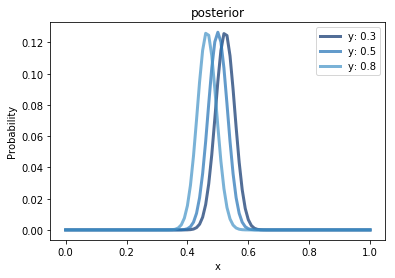

In [20]:
thinkplot.Pdfs(funky_coins) 
thinkplot.Config(title='posterior', xlabel='x', ylabel='Probability')

So as y increases, the coin becomes less skewed. This makes sense, when you consider what actually happens. Lets calculate what `true_heads` and `true_tails` become for different values of `y`:

In [21]:
def true_values(data, y):
    heads, tails = data
    true_heads = (1 - y) * heads + y * tails
    true_tails = (1 - y) * tails + y * heads
    print ('for {}, true_heads: {}, true_tails: {}'.format(y, true_heads, true_tails))

In [22]:
for y in possible_y:
    true_values((140, 110), y)

for 0.3, true_heads: 131.0, true_tails: 119.0
for 0.5, true_heads: 125.0, true_tails: 125.0
for 0.8, true_heads: 116.0, true_tails: 134.0


As y increases, a greater proportion of heads and tails are exchanged. Since there are more heads than tails (in the observed data), this means heads 'gives' more values than tails, so as y increases, this means more and more tails actually occured.

**Exercise** This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

In [23]:
import pandas as pd
from random import choice
from string import ascii_uppercase
from datetime import datetime, timedelta

In [24]:
class Link(Beta):
    def __init__(self, alpha=1, beta=1, label=None):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.label = label if label is not None else '_nolegend_'
        
        self.visited_users = set()
        self.upvoted_users = set()
        
    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (upvotes, total_views)
        """
        upvotes, total_views = data
        non_upvotes = total_views - upvotes
        self.alpha += upvotes
        self.beta += non_upvotes

In [25]:
class User(Beta):
    def __init__(self, alpha=1, beta=1, label=None):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.label = label if label is not None else '_nolegend_'
        
        self.upvotes = set()
        
    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (high_quality_upvotes, low_quality_upvotes)
            (where non_upvote is a view, but not an upvote)
        """
        hq_upvotes, lq_upvotes = data
        self.alpha += hq_upvotes
        self.beta += lq_upvotes

So now, I need to simulate a 'session', within which a bunch of users interact with some links.

For simplicity, I'll model any link with a mean probability over 0.5 as a high quality link.

In [26]:
class Session(object):
    """ A reddit session
    """
    def __init__(self, links=None, users=None):
        self.links = {}
        if links:
            for link in links:
                self.links[link] = Link(label=link)
        
        self.users = {}
        if users:
            for user in users:
                self.users[user] = User(label=user)
    
    def generate_random_data(self, num_links=100, num_users=10, num_actions=1000, upvote_ratio=0.3):
        """Generates a random dataframe of user-link interactions
        
        num_links: the number of links randomly generate (if none were defined when
            the class was initialized)
        num_uers: the number of users randomly generate (if none were defined when
            the class was initialized)
        num_actions: the number of actions to generate
        upvote_ratio: The ratio of viewed links which should also be upvotes
        
        returns:
            a dataframe of random activity, which can be input into Update()
        """
        
        # check if users and links have already been defined
        # if not, randomly create them
        if len(self.users) == 0:
            for i in range(num_users):
                username = ''.join(choice(ascii_uppercase) for i in range(8))
                self.users[username] = User(label=username)
        if len(self.links) == 0:
            for i in range(num_links):
                link = ''.join(choice(ascii_uppercase) for i in range(8))
                self.links[link] = Link(label=link)
        
        # randomly create user-link interactions
        user_sequence = []
        link_sequence = []
        upvote_sequence = []
        date_sequence = []
        event_timestamp = datetime.now()
        
        for i in range(num_actions):
            user_sequence.append(random.choice(self.users.keys()))
            link_sequence.append(random.choice(self.links.keys()))
            date_sequence.append(event_timestamp)
            event_timestamp += timedelta(days=1)
        
        upvote_sequence = np.array([False]*num_actions)
            
        mask = np.random.rand(num_actions) < 0.3
        upvote_sequence[mask] = True
            
        return pd.DataFrame(data={'timestamp': date_sequence,
                                  'user': user_sequence,
                                  'link': link_sequence,
                                  'upvote': upvote_sequence})
        
    
    def simulate_session(self, activity):
        """Simulates a session. The priors for all links and users
        are then updated.
        
        activity: A dataframe with the following 4 headers:
        ['timestamp', 'user', 'link', 'upvote']
        (This can be generated using `generate_random_data`)
        """
        activity = activity.sort_values('timestamp', ascending=False)
        
        # First, update the links' and users' attributes
        for _, action in activity.iterrows():
            if action.upvote:
                self.users[action.user].upvotes.add(action.link)
                self.links[action.link].upvoted_users.add(action.user)
            
            self.links[action.link].visited_users.add(action.user)
        
        # Next, run Update() for both the links
        self.good_links = set()
        for link in self.links:
            num_unique_visits = len(self.links[link].visited_users)
            num_upvotes = len(self.links[link].upvoted_users)
            self.links[link].Update((num_upvotes, num_unique_visits))
            link_score = self.links[link].Mean()
            if link_score > 0.5:
                self.good_links.add(link)
                
        for user in self.users:
            num_total_upvotes = len(self.users[user].upvotes)
            num_hq_upvotes = len(self.good_links.intersection(self.users[user].upvotes))
            num_lq_upvotes = num_total_upvotes - num_hq_upvotes
            self.users[user].Update((num_hq_upvotes, num_lq_upvotes))
            

In [27]:
reddit_session = Session()

In [28]:
random_data = reddit_session.generate_random_data()

In [29]:
random_data.head()

,link,timestamp,upvote,user
0,ZBCLUUVI,2018-03-09 14:54:27.045967,True,YMWHHTIJ
1,ZGAASZEF,2018-03-10 14:54:27.045967,False,PMQLMKUL
2,TVOSGHAH,2018-03-11 14:54:27.045967,False,PMQLMKUL
3,QZHSIGEL,2018-03-12 14:54:27.045967,True,PMQLMKUL
4,ZDENVMAV,2018-03-13 14:54:27.045967,False,ENATHMET


Now, I can see how the strengths of a link and a user evolve from the start to the end of the session.

In [30]:
random_link = random_data.iloc[random.choice(range(0, 1000))].link
random_user = random_data.iloc[random.choice(range(0, 1000))].user
print (random_link, random_user)

MWTQEZBE ENATHMET


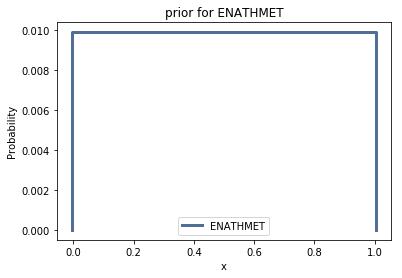

In [31]:
thinkplot.Pmf(reddit_session.users[random_user].MakePmf())
thinkplot.Config(title='prior for {}'.format(random_user), xlabel='x', ylabel='Probability')

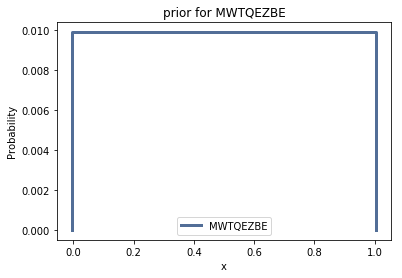

In [32]:
thinkplot.Pmf(reddit_session.links[random_link].MakePmf())
thinkplot.Config(title='prior for {}'.format(random_link), xlabel='x', ylabel='Probability')

These are uniform priors, as expected. The session can now be run

In [33]:
reddit_session.simulate_session(random_data)

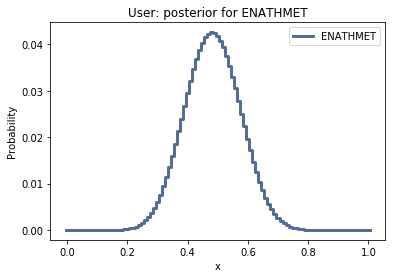

In [36]:
thinkplot.Pmf(reddit_session.users[random_user].MakePmf())
thinkplot.Config(title='User: posterior for {}'.format(random_user), xlabel='x', ylabel='Probability')

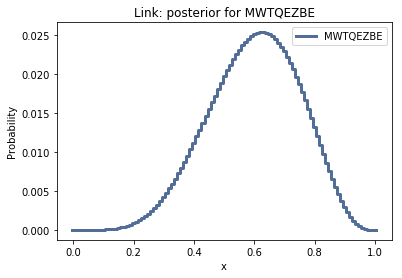

In [37]:
thinkplot.Pmf(reddit_session.links[random_link].MakePmf())
thinkplot.Config(title='Link: posterior for {}'.format(random_link), xlabel='x', ylabel='Probability')